# Force chains in emulsion gels


## About this notebook
In this notebook we perform the analysis of the experimental data. The data are stored in the `data` folder

In [4]:
ls data

phi_p_0.8/ phi_p_1.2/ phi_p_1.5/ phi_p_1.7/ phi_p_2.0/ phi_p_2.3/


Each folder contains pure `txt` files with the original data from Jun and `xyz` files that can be rendered in `Ovito` or `VMD`.

In [5]:
ls data/phi_p_0.8/

Contact_center.txt   contacts.xyz         particle_center.txt
TCC/                 coords.xyz
box.txt              inputparameters.ini


Lengthy and complex algorithms should be stored in the folder `src`

In [81]:
ls src

__pycache__/ io.py


## Visualising the data

We first import the basic numerical and visuaisation modules. If they are missing, thhey can be install via `pip install module-name`. For example 

`pip install ipyvolume`

In [44]:
import numpy as np
import scipy as sp
import ipyvolume as ipv
import matplotlib.pyplot as plt

In [13]:
%load_ext autoreload #to update the custom modules every time a modification is made
%autoreload 2
from src import io

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
centres = io.Centres("data/phi_p_0.8/coords.xyz")
contacts = io.Contacts("data/phi_p_0.8/contacts.xyz")

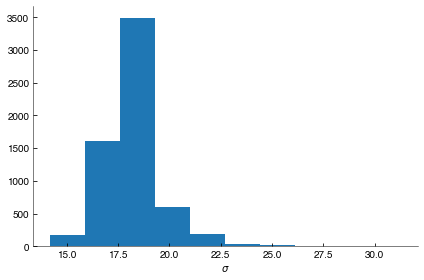

In [53]:
plt.hist(2*centres.radius); plt.xlabel('$\sigma$');

In [82]:
x, y, z = centres.unpack()
color = np.array([(x-x.min())/x.ptp(),np.ones_like(x), np.ones_like(x)]).T
ipv.scatter(x, y, z, size=centres.radius/2.5, marker="sphere", color=color)

x, y, z = contacts.unpack()
ipv.scatter(x, y, z, size=0.9, marker="sphere", color='red')
ipv.show()

(array([4.7540e+03, 1.0014e+04, 6.0570e+03, 1.4000e+01, 9.0000e+00,
        6.0000e+00, 1.2000e+01, 5.0000e+00, 5.0000e+00, 4.0000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

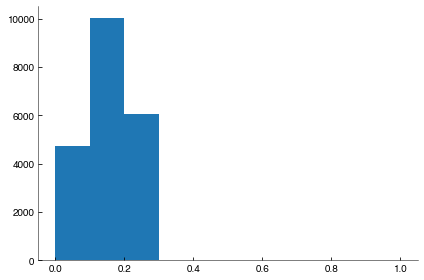

In [75]:
plt.hist(u)